In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import h5py

# tf.get_logger().setLevel('ERROR')
# !curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

In [ ]:
# for layer in pretrained_model.layers[:FINE_TUNE_AT]: layer.trainable = False
# for layer in pretrained_model.layers[FINE_TUNE_AT:]: layer.trainable = True

# from tensorflow.keras.optimizers import SGD

# model.compile(
#     optimizer = SGD(learning_rate=1e-4, momentum=0.9),
#     loss = 'categorical_crossentropy',
#     metrics = ['accuracy']
# )

# history_fine = model.fit(
#     generated_train_data,
#     validation_data = generated_validate_data,
#     validation_steps = generated_validate_data.n // BATCH_SIZE,
#     steps_per_epoch = generated_train_data.n // BATCH_SIZE,
#     epochs = TOTAL_EPOCHS,
#     initial_epoch = history.epoch[-1],
#     callbacks = [fine_tune_checkpointer, early_stopping],
#     verbose = 1,
# )

# model.save(FINE_TUNE_MODEL_TRAINED)
# acc += history_fine.history['accuracy']
# loss += history_fine.history['loss']
# val_acc += history_fine.history['val_accuracy']
# val_loss += history_fine.history['val_loss']
# plt.figure(figsize=(20, 5))
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([min(plt.ylim()), 1])
# plt.plot([INITIAL_EPOCHS - 7, INITIAL_EPOCHS - 7], plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([min(plt.ylim()), max(plt.ylim())])
# plt.plot([INITIAL_EPOCHS - 7, INITIAL_EPOCHS - 7], plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.savefig(FINE_TUNE_MODE_FIG)
# plt.show()

# Import dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input,MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau


In [ ]:
path = '/content/drive/MyDrive'
os.chdir(path)

In [ ]:
# Move dataset to /tmp cause reading files from Drive is very slow
!cp vietnamese-foods.zip /tmp
!unzip -q /tmp/vietnamese-foods.zip -d /tmp

# Setup path

In [ ]:
TRAIN_PATH = '/tmp/Images/Train'
VALIDATE_PATH = '/tmp/Images/Validate'
TEST_PATH = '/tmp/Images/Test'

In [ ]:
PATH = '/content/drive/MyDrive/kqcv'

BASE_MODEL_BEST = os.path.join(PATH, 'duc8245kc_DenseNet201_best.hdf5')
BASE_MODEL_TRAINED = os.path.join(PATH, 'duc8245kc5_DenseNet201.hdf5')
Weight_MODEL_TRAINED = os.path.join(PATH, 'duc8245kc5_DenseNet201_weight.hdf5')
BASE_MODEL_FIG = os.path.join(PATH, 'duc8245kc5_DenseNet201_fig.jpg')

# Preparing data

In [ ]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64

In [ ]:

train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    # width_shift_range = 0.1,
    # height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)
validate_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
generated_train_data = train_generator.flow_from_directory(TRAIN_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_validate_data = validate_generator.flow_from_directory(VALIDATE_PATH, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
generated_test_data = test_generator.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)

Found 17581 images belonging to 30 classes.
Found 2515 images belonging to 30 classes.
Found 5040 images belonging to 30 classes.


# Model implement

In [ ]:
CLASSES = 30
INITIAL_EPOCHS = 9

## Define the model

In [ ]:
input_layer = Input(shape=(300, 300, 3))
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_layer)
last_output = pretrained_model.output
x = MaxPooling2D(pool_size=(2, 2))(last_output)
x = GlobalAveragePooling2D()(last_output)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)


outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

74836368/74836368 [==============================] - 4s 0us/step


## Callbacks

In [ ]:
base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST,
    save_best_only = True,
    verbose = 1
)


# Stop if no improvement after 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
relu_cb= ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

## Stage 1: Transfer learning

In [ ]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping, relu_cb],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)
model.save_weights(Weight_MODEL_TRAINED)

Epoch 1/9
274/274 [==============================] - ETA: 0s - loss: 1.6083 - accuracy: 0.5204
Epoch 1: val_loss improved from inf to 1.07513, saving model to /content/drive/MyDrive/kqcv/duc8245kc_DenseNet201_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 758s 3s/step - loss: 1.6083 - accuracy: 0.5204 - val_loss: 1.0751 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 2/9
274/274 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.6717
Epoch 2: val_loss improved from 1.07513 to 0.98200, saving model to /content/drive/MyDrive/kqcv/duc8245kc_DenseNet201_best.hdf5
274/274 [==============================] - 679s 2s/step - loss: 1.0777 - accuracy: 0.6717 - val_loss: 0.9820 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 3/9
274/274 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.7168
Epoch 3: val_loss did not improve from 0.98200
274/274 [==============================] - 702s 3s/step - loss: 0.9348 - accuracy: 0.7168 - val_loss: 0.9958 - val_accuracy: 0.7047 - lr: 0.0010
Epoch 4/9
274/274 [==============================] - ETA: 0s - loss: 0.7181 - accuracy: 0.7786
Epoch 4: val_loss improved from 0.98200 to 0.80913, saving model to /content/drive/MyDrive/kqcv/duc8245kc

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

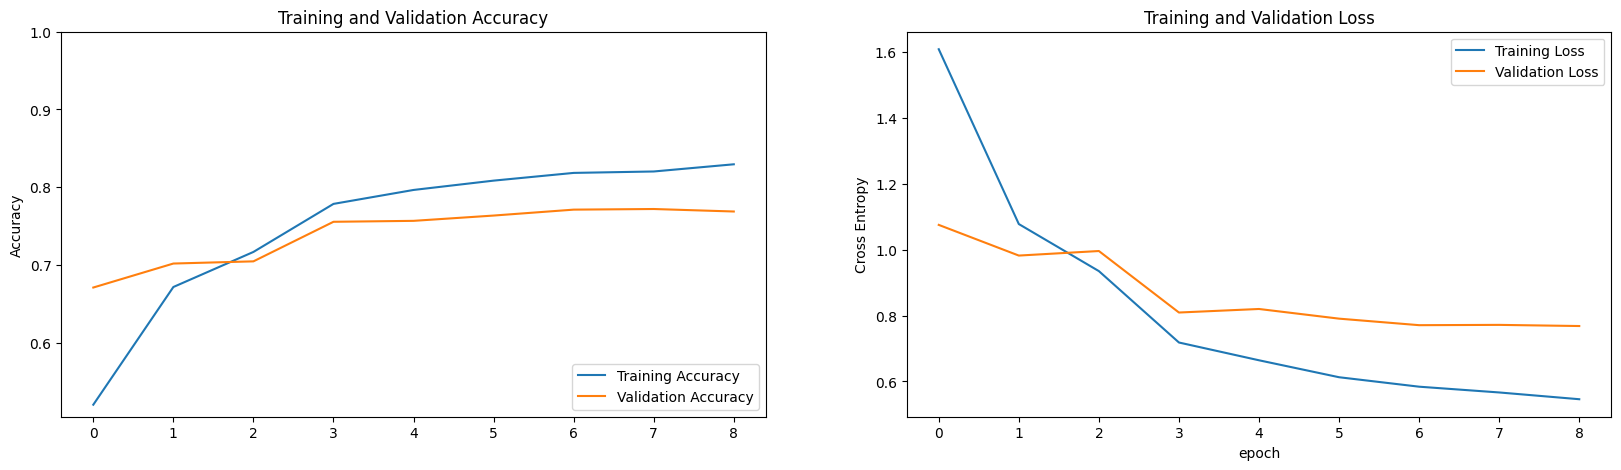

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

158/158 [==============================] - 109s 612ms/step - loss: 0.7588 - accuracy: 0.7772
Test accuracy: 0.7771825194358826
